## Data Prepapation 

### 1.1 Engineer time features 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df = pd.read_csv('ElectronicsProductsPricingData.csv')

# Converting dates immediately for feature engineering
df['dateUpdated'] = pd.to_datetime(df['dateUpdated'])
df['dateAdded'] = pd.to_datetime(df['dateAdded'])
df['prices.dateSeen'] = pd.to_datetime(df['prices.dateSeen'], errors="coerce")

print(f"Successfully loaded {len(df)} records from ElectronicsProductsPricingData.csv")

C:\Users\ayush\AppData\Local\Temp\ipykernel_15368\839530234.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['prices.dateSeen'] = pd.to_datetime(df['prices.dateSeen'], errors="coerce")


Successfully loaded 7249 records from ElectronicsProductsPricingData.csv


In [21]:

# 2. Extract features
df['day_of_week'] = df['prices.dateSeen'].dt.dayofweek
df['month'] = df['prices.dateSeen'].dt.month
df['week_of_year'] = df['prices.dateSeen'].dt.isocalendar().week

# 3. Binary flag (Converted to 1/0 for the model)
df['is_thursday'] = (df['day_of_week'] == 3)

# Preview
df[['prices.dateSeen', 'day_of_week', 'week_of_year', 'is_thursday']]



,prices.dateSeen,day_of_week,week_of_year,is_thursday
0,NaT,NaN,<NA>,False
1,2017-12-14 06:00:00+00:00,3.0,50,True
2,2017-09-08 05:00:00+00:00,4.0,36,False
3,2017-10-10 05:00:00+00:00,1.0,41,False
4,2017-08-28 07:00:00+00:00,0.0,35,False
...,...,...,...,...
7244,2017-10-10 08:00:00+00:00,1.0,41,False
7245,2018-06-01 12:00:00+00:00,4.0,22,False
7246,2017-05-18 05:00:00+00:00,3.0,20,True
7247,2017-08-28 11:00:00+00:00,0.0,35,False


#### 1.1.1 Temporal Feature Extraction
As per the Phase 2 requirements, we focus on high-resolution time features: day_of_week, month, week_of_year, and is_thursday. Justification: Thursdays are often identified as key re-pricing days in retail as stores prepare for weekend traffic. Utility: These features provide the categorical "hooks" for the Stage 1 Classification model.

### 1.2 Create lag features 

### 1.3 Handle =% discount - build two stage model

In [12]:
# compute a percent‑discount column from the price fields
# discount_percent = ((regular_price - sale_price) / regular_price) * 100
# assume amountMax is the non‑sale price and amountMin the current price;
# guard against division by zero.
df['discount_percent'] = np.where(
	df['prices.amountMax'] > 0,
	100 * (df['prices.amountMax'] - df['prices.amountMin']) / df['prices.amountMax'],
	0
)

# 1. Creating the Binary Classification Target (Stage 1)
# 1 = Discounted (Sale), 0 = Not Discounted (Regular Price)
df['is_discounted'] = (df['discount_percent'] > 0).astype(int)

# 2. Prepare the Regression Target (Stage 2)
# We isolate actual discount values to prevent zero-inflation from biasing the model
actual_discounts = df.loc[df['is_discounted'] == 1, 'discount_percent']

#### 1.2.1 Handling 0% Discounts: Two-Stage Methodology
To address the high frequency of zero-discount days, we implement a two-stage approach: 1. Classification (Stage 1): Predicting the probability of a sale occurring based on time features. 2. Regression (Stage 2): Estimating the depth of the discount once a sale event is confirmed. Benefit: This architectural decision minimizes the error (MAE/RMSE) caused by zero-inflated target variables.

C:\Users\ayush\AppData\Local\Temp\ipykernel_3504\187368602.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_discounted', data=df, palette='Set2')


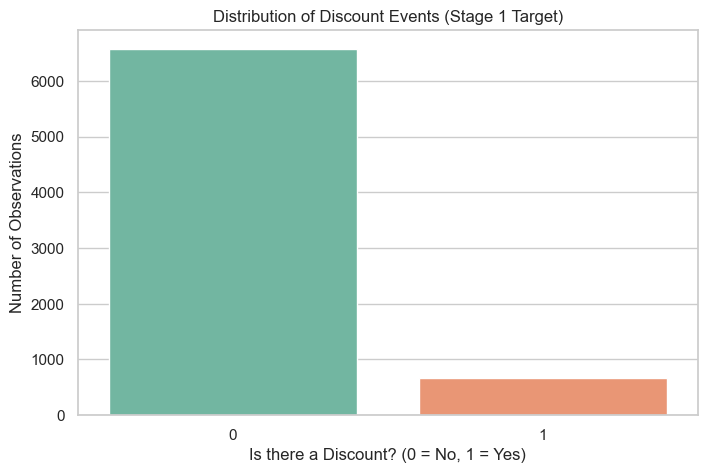

In [ ]:

plt.figure(figsize=(8, 5))
sns.countplot(x='is_discounted', data=df, palette='Set2')
plt.title('Distribution of Discount Events (Stage 1 Target)')
plt.xlabel('Is there a Discount? (0 = No, 1 = Yes)')
plt.ylabel('Number of Observations')
plt.show()

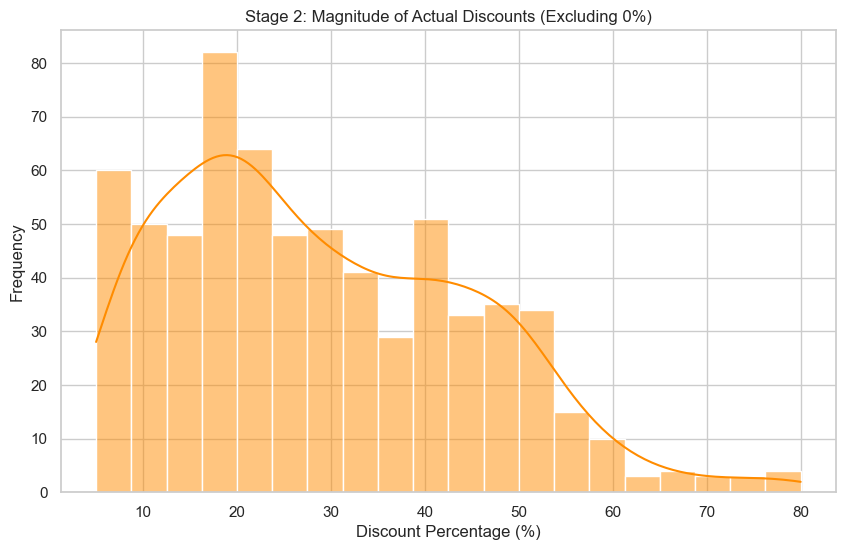

In [ ]:
# subset containing ONLY actual discounts (Stage 2 data)
df_discounted = df[df['is_discounted'] == 1]

# Visualization: Distribution of Non-Zero Discounts
plt.figure(figsize=(10, 6))
sns.histplot(df_discounted['discount_percent'], bins=20, kde=True, color='darkorange')
plt.title('Stage 2: Magnitude of Actual Discounts (Excluding 0%)')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Frequency')
plt.show()

## Baseline 